## Process ERA5 file Tutorial

This tutorial will walk through processing forecast data from ERA5 using xarray.

Authors:
* Jeffrey Sward (jas983@cornell.edu), Cornell University, January 2020

In [4]:
# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf

# Import the pvlib module
if sys.platform == 'linux':
    sys.path.append('/home/jsward/Documents/01_Research/01_Renewable_Analysis/WRF/pvlib-python')
import pvlib
from pvlib.wrfcast import WRF

# Import the optwrf module
import optwrf

In [5]:
# Find the absolute file path to your pvlib installation
optwrf_abspath = os.path.dirname(os.path.abspath(inspect.getfile(optwrf)))

# absolute path to ERA data file
era_file1 = os.path.join(optwrf_abspath, 'data', 'EastUS_e5.oper.an.sfc.228_246_100u.ll025sc.2011010100_2011013123.nc')
era_file2 = os.path.join(optwrf_abspath, 'data', 'EastUS_e5.oper.an.sfc.228_247_100v.ll025sc.2011010100_2011013123.nc')

# Read in the ERA file using the xarray open_dataset method
era_data1 = xr.open_dataset(era_file1)
era_data2 = xr.open_dataset(era_file2)

In [6]:
era_data = xr.merge([era_data1, era_data2])
era_data

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 121, time: 744)
Coordinates:
  * latitude   (latitude) float64 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 294.5 294.8 295.0
  * time       (time) datetime64[ns] 2011-01-01 ... 2011-01-31T23:00:00
Data variables:
    VAR_100U   (time, latitude, longitude) float32 ...
    utc_date   (time) int32 2011010100 2011010101 ... 2011013122 2011013123
    VAR_100V   (time, latitude, longitude) float32 ...

In [7]:
# Calculate the 100m wind speed
wind_speed100 = np.sqrt(era_data['VAR_100U']**2 + era_data['VAR_100V']**2)

# Calculate wind power density (W * m -2)
air_density = 1000 
wpd = 0.5 * air_density * (wind_speed100) ** 3
era_data['wpd'] = wpd
era_data

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 121, time: 744)
Coordinates:
  * latitude   (latitude) float64 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * longitude  (longitude) float64 265.0 265.2 265.5 265.8 ... 294.5 294.8 295.0
  * time       (time) datetime64[ns] 2011-01-01 ... 2011-01-31T23:00:00
Data variables:
    VAR_100U   (time, latitude, longitude) float32 -5.118103 ... -3.841217
    utc_date   (time) int32 2011010100 2011010101 ... 2011013122 2011013123
    VAR_100V   (time, latitude, longitude) float32 -7.5160675 ... -1.6359863
    wpd        (time, latitude, longitude) float32 375941.2 ... 36388.855

In [13]:
# # Download the ERA file containing surface solar radiation downward (ssrd)
# filelist = ['e5.oper.fc.sfc.accumu/201101/e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011010106_2011011606.nc']
# dspath = 'http://rda.ucar.edu/data/ds633.0/'
# runwrf.rda_download(filelist, dspath)

100.000 % Completed
Done downloading data from RDA!


In [8]:
# # Use NCO tools to extract the Northeast region (only works if NCO is installed)
# CMD_REDUCE = 'ncks -d longitude,265.,295. -d latitude,30.,50. e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011010106_2011011606.nc EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011010106_2011011606.nc'
# os.system(CMD_REDUCE)

0

In [10]:
# Read in the ERA file using the xarray open_dataset method
era_file3 = 'EastUS_e5.oper.fc.sfc.accumu.128_169_ssrd.ll025sc.2011010106_2011011606.nc'
era_data3 = xr.open_dataset(era_file3)
era_data3

<xarray.Dataset>
Dimensions:                (forecast_hour: 12, forecast_initial_time: 30, latitude: 81, longitude: 121)
Coordinates:
  * forecast_hour          (forecast_hour) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * forecast_initial_time  (forecast_initial_time) datetime64[ns] 2011-01-01T06:00:00 ... 2011-01-15T18:00:00
  * latitude               (latitude) float64 50.0 49.75 49.5 ... 30.25 30.0
  * longitude              (longitude) float64 265.0 265.2 265.5 ... 294.8 295.0
Data variables:
    SSRD                   (forecast_initial_time, forecast_hour, latitude, longitude) float32 ...
    utc_date               (forecast_initial_time) int32 ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 18:48:19 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Jan 20 10:52:54 2020: ncks -d longitude,265.,29...
    NCO:                  4.7.2

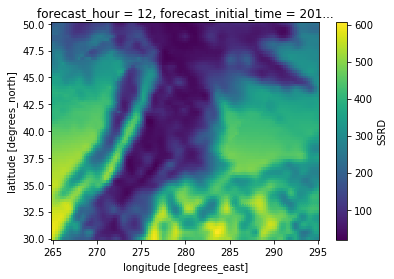

In [11]:
# Test visualization plot
ssrd = era_data3.SSRD.sel(forecast_initial_time='2011-01-01 06:00:00',forecast_hour=12)
ghi = ssrd/3600
ghi.plot()

In [13]:
# Set the utc_date as a coordinate
era_data3 = era_data3.set_coords('utc_date')
era_data3

<xarray.Dataset>
Dimensions:                (forecast_hour: 12, forecast_initial_time: 30, latitude: 81, longitude: 121)
Coordinates:
  * forecast_hour          (forecast_hour) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * forecast_initial_time  (forecast_initial_time) datetime64[ns] 2011-01-01T06:00:00 ... 2011-01-15T18:00:00
  * latitude               (latitude) float64 50.0 49.75 49.5 ... 30.25 30.0
  * longitude              (longitude) float64 265.0 265.2 265.5 ... 294.8 295.0
    utc_date               (forecast_initial_time) int32 ...
Data variables:
    SSRD                   (forecast_initial_time, forecast_hour, latitude, longitude) float32 ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 18:48:19 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Jan 20 10:52:54 2020: ncks -d longitude,265.,29...
    NCO:                  4.7.2

In [21]:
era_data3.SSRD.shape

(30, 12, 81, 121)

In [25]:
# Create a new date range 
ds = xr.Dataset({'time': pd.date_range(start='2011-01-01T06:00:00', freq='H', 
                                           periods=(len(era_data3.forecast_hour) * len(era_data3.forecast_initial_time)))})
ds

<xarray.Dataset>
Dimensions:  (time: 360)
Coordinates:
  * time     (time) datetime64[ns] 2011-01-01T06:00:00 ... 2011-01-16T05:00:00
Data variables:
    *empty*

In [26]:
# Add the date range to the intial dataset
era_data3['time'] = ds['time']
era_data3

In [29]:
# Stack the existing dimensions
test = era_data3.stack(intial_time_and_hour=('forecast_initial_time', 'forecast_hour'))
test

<xarray.Dataset>
Dimensions:                (intial_time_and_hour: 360, latitude: 81, longitude: 121, time: 360)
Coordinates:
  * latitude               (latitude) float64 50.0 49.75 49.5 ... 30.25 30.0
  * longitude              (longitude) float64 265.0 265.2 265.5 ... 294.8 295.0
    utc_date               (intial_time_and_hour) int32 2011010106 ... 2011011518
  * time                   (time) datetime64[ns] 2011-01-01T06:00:00 ... 2011-01-16T05:00:00
  * intial_time_and_hour   (intial_time_and_hour) MultiIndex
  - forecast_initial_time  (intial_time_and_hour) datetime64[ns] 2011-01-01T06:00:00 ... 2011-01-15T18:00:00
  - forecast_hour          (intial_time_and_hour) int64 1 2 3 4 5 ... 9 10 11 12
Data variables:
    SSRD                   (latitude, longitude, intial_time_and_hour) float32 0.0 ... 0.0
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.6.1
    CONVERSION_PLATFORM:  Linux casper18 3.10.0-693.21.1.el7.x86_64 #1 SMP We...
    CONVERSION_DATE:      Fri Aug 23 18:48:19 MDT 2019
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Mon Jan 20 10:52:54 2020: ncks -d longitude,265.,29...
    NCO:                  4.7.2

In [30]:
# Swap the initial_time_and_hour dimension with time
test2 = test.swap_dims({"intial_time_and_hour": "time"})
test2

ValueError: replacement dimension 'time' is not a 1D variable along the old dimension 'intial_time_and_hour'

In [ ]:
# Drop forecast_inital_time and forecast_hour dimensions


In [85]:
# Extract SSRD and convert to GHI
tidx = 6
timestr = f'2011-01-01 {tidx}:00:00'

initial_time = era_data3['forecast_initial_time']
ssrd1 = era_data3.SSRD.sel(forecast_initial_time='2011-01-01 06:00:00')
ssrd2 = era_data3.SSRD.sel(forecast_initial_time='2011-01-01 18:00:00')
ssrd = xr.concat([ssrd1, ssrd2], 'forecast_initial_time')
ssrd



<xarray.DataArray 'SSRD' (forecast_initial_time: 2, forecast_hour: 12, latitude: 721, longitude: 1440)>
array([[[[      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         ...,
         [1696832., 1697024., 1697216., ..., 1696320., 1696512.,
          1696704.],
         [1697152., 1697280., 1697344., ..., 1696896., 1697024.,
          1697088.],
         [1698624., 1698624., 1698624., ..., 1698624., 1698624.,
          1698624.]],

        [[      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         ...,
         [1705664., 1705856., 1706048., ..., 1705152., 1705344.,
          1705536.],
         [1701184., 1701248., 1701376., ..., 1700928., 1700992.,
          1701120.],
         [1698176., 1698176., 1698176., ..., 1698176., 1698176.,
          1698176.]],

        [[      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         ...,
         [1713472., 1713664., 1713792., ..., 1713024., 1713216.,
          1713344.],
         [1704768., 1704832., 1704896., ..., 1704576., 1704640.,
          1704704.],
         [1697536., 1697536., 1697536., ..., 1697536., 1697536.,
          1697536.]],

        ...,

        [[      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         ...,
         [1699200., 1699328., 1699328., ..., 1699584., 1699456.,
          1699328.],
         [1695232., 1695232., 1695104., ..., 1695488., 1695360.,
          1695360.],
         [1687040., 1687040., 1687040., ..., 1687040., 1687040.,
          1687040.]],

        [[      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         ...,
         [1684480., 1684608., 1684608., ..., 1683712., 1683968.,
          1684224.],
         [1687552., 1687424., 1687424., ..., 1687040., 1687296.,
          1687424.],
         [1684864., 1684864., 1684864., ..., 1684864., 1684864.,
          1684864.]],

        [[      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         ...,
         [1651584., 1651712., 1651840., ..., 1652352., 1652096.,
          1651840.],
         [1665024., 1665024., 1665152., ..., 1665536., 1665280.,
          1665152.],
         [1682304., 1682304., 1682304., ..., 1682304., 1682304.,
          1682304.]]],


       [[[      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
                0.],
         ...,
         [1661248., 1661056., 1660672., ..., 1661888., 1661568.,
          1661376.],
         [1672640., 1672384., 1672128., ..., 1673088., 1672896.,
          1672768.],
         [1684608., 1684608., 1684608., ..., 1684608., 1684608.,
          1684608.]],

        [[      0.,       0.,       0., ...,       0.,       0.,
                0.],
         [      0.,       0.,       0., ...,       0.,       0.,
     